In [1]:
# grid size

def run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p):
    print("start test ngrid = {}, n_sweep = {}, ndiv_r = {}, ndiv_t = {}, ndiv_p = {}".format(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))

    # create simulation file by running make_test_model.py
    import os
    os.system('python3 make_test_model.py --n_rtp {} {} {} --n_sweep {} --ndiv_rtp {} {} {}'. format(n_grid, n_grid, n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))

    #
    # run simulatoin and store time file
    #
    total_nprocs = n_sweep * ndiv_r * ndiv_t * ndiv_p
    print('total number of processes: {}'.format(total_nprocs))

    # run simulation
    tomo_exec = "../../build/TOMOATT"
    mpi_path = "../../external_libs/local_mpi_hdf5/bin/"
    os.system('{}/mpirun  --use-hwthread-cpus -np {} {} -i input_params_{}-{}-{}_{}-{}-{}-{}.yml'.format(mpi_path,total_nprocs, tomo_exec, n_grid, n_grid, n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))

    # change filename of time.txt to time_{}-{}-{}_{}-{}-{}-{}.txt
    os.system('mv time.txt time_{}-{}-{}_{}-{}-{}-{}.txt'.format(n_grid, n_grid, n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))


In [3]:
n_grid = 150
n_sweep = 12
ndiv_r = 1
ndiv_t = 1
ndiv_p = 1 

run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)

#n_sweep = 2
#run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
#
#n_sweep = 4
#run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
#
#n_sweep = 8
#run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
#
#n_sweep = 12
#run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
#

start test ngrid = 150, n_sweep = 12, ndiv_r = 1, ndiv_t = 1, ndiv_p = 1
depminmax 301.0 -29.0
1254240
total number of processes: 12
mpi initialized.
------------------------------------------------------
start TOMOATT solver.
------------------------------------------------------
parameter file read done.
mpi initialized.
------------------------------------------------------
start TOMOATT solver.
------------------------------------------------------
parameter file read done.
mpi initialized.
------------------------------------------------------
start TOMOATT solver.
------------------------------------------------------
parameter file read done.
mpi initialized.
------------------------------------------------------
start TOMOATT solver.
------------------------------------------------------
parameter file read done.
mpi initialized.
------------------------------------------------------
start TOMOATT solver.
------------------------------------------------------
parameter file rea

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


###### Swapping src and rec. (only regional events will be processed) ######

read input file successfully.
###### Swapping src and rec. (only regional events will be processed) ######

read input file successfully.
###### Swapping src and rec. (only regional events will be processed) ######

read input file successfully.
###### Swapping src and rec. (only regional events will be processed) ######
###### Swapping src and rec. (only regional events will be processed) ######

read input file successfully.
###### Swapping src and rec. (only regional events will be processed) ######

read input file successfully.
###### Swapping src and rec. (only regional events will be processed) ######

read input file successfully.
###### Swapping src and rec. (only regional events will be processed) ######

read input file successfully.
###### Swapping src and rec. (only regional events will be processed) ######

read input file successfully.
###### Swapping src and rec. (only regional events will be 

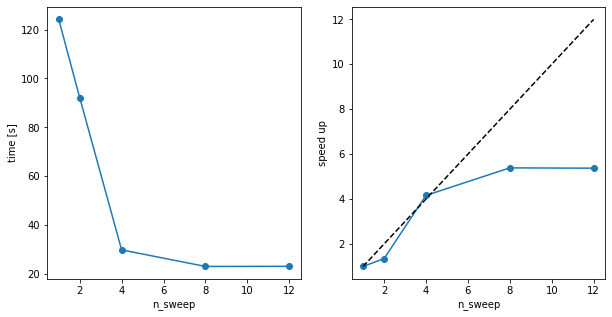

In [2]:
# read time*.txt and plot

import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted

# grep time_*.txt
import glob
#time_files = glob.glob('time_*.txt')
time_files = glob.glob('time_100*.txt')
time_files = natsorted(time_files)

# read time*.txt and get parameter from filename
n_grid = []
n_sweep = []
ndiv_r = []
ndiv_t = []
ndiv_p = []
time = []
for time_file in time_files:
    with open(time_file, 'r') as f:
        lines = f.readlines()
        time.append(float(lines[0].split(":")[-1]))
    n_grid.append(int(time_file.split('_')[1].split('-')[0]))
    n_sweep.append(int(time_file.split('_')[2].split('-')[0]))
    ndiv_r.append(int(time_file.split('_')[2].split('-')[1]))
    ndiv_t.append(int(time_file.split('_')[2].split('-')[2]))
    ndiv_p.append(int(time_file.split('_')[2].split('-')[3].split(".")[0]))

# plot time and speed up
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(n_sweep, time, 'o-')
plt.xlabel('n_sweep')
plt.ylabel('time [s]')

plt.subplot(1, 2, 2)
plt.plot(n_sweep, time[0]/np.array(time), 'o-')
plt.xlabel('n_sweep')
plt.ylabel('speed up')
# write ideal
plt.plot(n_sweep, n_sweep, 'k--')

